# Shapes Gen

## Methodology:

1. Draw a matrix of 0s indicating nothing is taken
    1. 0 - not taken
    1. 1 - taken
2. Each polygon gets its own numpy matrix


Fill using growing bodies:
- as the organsim gets heavier the probability of expanding reduces and theoretically it will stop at some point

In [3]:
# !conda install -y shapely

Channels:
 - defaults
 - conda-forge
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /home/ankush/miniconda3/envs/vit

  added / updated specs:
    - shapely


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2024.2.2           |  py310h06a4308_0         159 KB
    geos-3.8.0                 |       he6710b0_0         961 KB
    openssl-3.0.13             |       h7f8727e_0         5.2 MB
    shapely-2.0.1              |  py310h006c72b_0         433 KB
    ------------------------------------------------------------
                                           Total:         6.7 MB

The following NEW packages will be INSTALLED:

  geos               pkgs/main/linux-64::geos-3.8.0-he6710b0_0 
  shapely            pkgs/main/linux-64::shapely-2.0.1-py310h006c72b_0 

The following packages will be UPDATED:

  ca-certificates    conda-forge::ca-c

In [1]:
import numpy as np
import random
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MatPoly
from shapely.geometry import Polygon, Point, MultiPoint, MultiPolygon
from typing import List

ModuleNotFoundError: No module named 'scipy'

In [2]:
def genPoints():
    return [Point(random.random(), random.random()) for i in range(10)]

def generateShape():
    # get points
    points = MultiPoint(genPoints())
    
    # generate convex hull
    shape = points.convex_hull
    
    # return one mask
    return shape

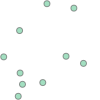

In [3]:
MultiPoint(genPoints())

In [2]:
def genCenterPoints(poly_ext: Polygon, n_points: int):
    points = []
    while len(points) < n_points:
        p = Point(random.random(), random.random())
        
        if poly_ext.contains(p):
            points.append(p)
            
    return points

def getPolyPoints(poly_ext: Polygon, n_points: int, center: Point, poly_children: List[Polygon]=[], std:float=0.1) -> List[Polygon]:
    points = []
    while len(points) < n_points:
        p = Point(random.normalvariate(center.x, std), random.normalvariate(center.y, std))
        
        if poly_ext.contains(p):
            inside = False
            for poly in poly_children:
                inside = poly.contains(p)
            if inside == False:
                points.append(p)
            
    return points

def generateShape(poly_ext: Polygon, n_child=3, extend=0.1, res=30):
    # get n points inside polygon as centroids for inner masks
    n_child = random.randint(2, n_child)
    centers = genCenterPoints(poly_ext, n_child)
    
    polygons = []
    points = []
    for c in centers:
        # polygons.append(Polygon(getPolyPoints(poly_ext, 10, c, polygons, 0.1)).convex_hull)
        p = getPolyPoints(poly_ext, res, c, polygons, extend)
        polygons.append(Polygon(p).convex_hull)
        points.extend(p)
        
    r_polys = [polygons[0]]
    for p in polygons:
        intersect = False
        for r in r_polys:
            if r.intersects(p):
                intersect = True
        
        if intersect == False:
            r_polys.append(p)
        
    return r_polys

In [5]:
poly = [(0,0), (0,1/2), (1/2,1/2), (1/2,0)]

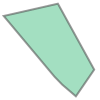

In [7]:
MultiPolygon(generateShape(Polygon(poly), 3))

In [8]:
# def fillMatrix(n, multi_polygon):
    
#     # Create an empty NumPy matrix
#     matrix = np.zeros((n, n), dtype=bool)

#     # Define the resolution of the matrix
#     resolution = 1 / n

#     # Iterate over each cell in the matrix
#     for i in range(n):
#         for j in range(n):
#             # Compute the coordinates of the cell
#             x = i * resolution
#             y = j * resolution
            
#             # Create a Point object representing the cell
#             point = Point(x, y)
            
#             # Check if the point is inside any of the polygons
#             if multi_polygon.contains(point):
#                 matrix[i, j] = True
                
#     return matrix

In [39]:
def genPolyMasks(levels=3, n_child=3, res=30):
    poly_ext = Polygon([(0,0), (0,1), (1,1), (1,0)])
    
    polygons = [poly_ext]
    extend = 1/(n_child)
    ret = [MultiPolygon(polygons)]
    while levels:
        
        child_polys = []
        while polygons:
            p = polygons.pop()
        
            # annotate
            x = generateShape(Polygon(p), n_child, extend, res)
            child_polys.extend(x)
            
            extend = extend/2
        
        ret.append(MultiPolygon(child_polys.copy()))
        polygons = child_polys
        
        levels -= 1
        
        if random.random() > 0.8:
            break
    
    
    return ret

genPolyMasks()

[<MULTIPOLYGON (((0 0, 0 1, 1 1, 1 0, 0 0)))>,
 <MULTIPOLYGON (((0.742 0.186, 0.509 0.194, 0.073 0.31, 0.25 0.833, 0.278 0.8...>,
 <MULTIPOLYGON (((0.835 0.568, 0.758 0.578, 0.416 0.625, 0.424 0.746, 0.484 0...>,
 <MULTIPOLYGON (((0.728 0.598, 0.441 0.627, 0.481 0.842, 0.668 0.878, 0.728 0...>]

In [141]:
l = genPolyMasks(2)

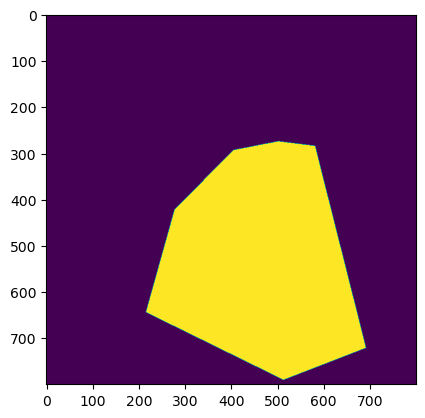

In [143]:
plt.imshow(fillMatrix(800, l[2]))

In [4]:
def fillMatrix(n, multi_polygon):
    # Create an empty NumPy matrix
    matrix = np.zeros((n, n), dtype=np.uint8)

    for polygon in multi_polygon.geoms:
        points = np.array(
            [(j*n, i*n) for i, j in polygon.exterior.coords], 
            dtype=np.int32)
        cv2.fillPoly(matrix, [points], (255,255,255))
                
    return matrix

In [16]:
def generateMatrices(size:int, polygons: List[MultiPolygon]):
    matrices = []
    for poly in polygons[1:]:
        matrices.append(fillMatrix(size, poly))
        
    matrices.append(np.zeros_like(matrices[0]))
        
    return matrices

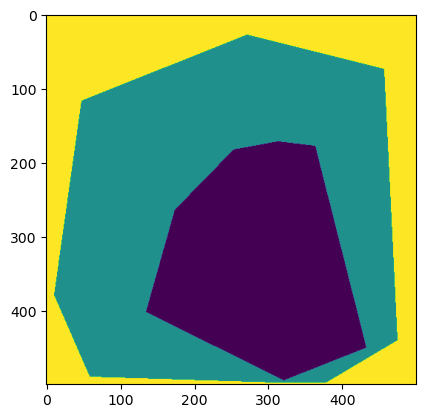

In [146]:
plt.imshow(sum(generateMatrices(500, l)))

In [6]:
from matplotlib.patches import Polygon as MPLPolygon
import cv2
from PIL import Image

In [17]:
(random.randint(0, 255),random.randint(0, 255),random.randint(0, 255))

(137, 2, 130)

In [7]:
def generateImages(size:int, polygons: List[MultiPolygon], type: int):
    """
    1: solid colours
    2: simple textures
    3: complex textures
    """
    image = np.zeros((size, size, 3), dtype=np.uint8)
    if type == 1:        
        # Iterate over each polygon in the MultiPolygon
        for mult in polygons:
            for polygon in mult.geoms:
                points = np.array(
                    [(j*size, i*size) for i, j in polygon.exterior.coords], 
                    dtype=np.int32)
                cv2.fillPoly(image, [points], (random.randint(0, 255),random.randint(0, 255),random.randint(0, 255)))

        return image
    
    if type in [2,3]:
        # Iterate over each polygon in the MultiPolygon
        for mult in polygons:
            interim = np.zeros((size, size, 3), dtype=np.uint8)
            for polygon in mult.geoms:
                points = np.array(
                    [(j*size, i*size) for i, j in polygon.exterior.coords], 
                    dtype=np.int32)
                cv2.fillPoly(interim, [points], (255,255,255))
                
                # removing inside block
                image -= interim
                image[interim > 0] = 0
                
                texture = cv2.imread(f"./{'textures' if type==2 else 't3images'}/{random.randint(1, 8 if type==2 else 16)}.jpg")
                texture = cv2.resize(texture, (size, size))
                # resul = cv2.addWeighted(texture, 0.5, mask, 0.5, 0)
                interim = cv2.bitwise_and(texture, interim)
                # adding interm to cutout
                image += interim
                
        
        return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

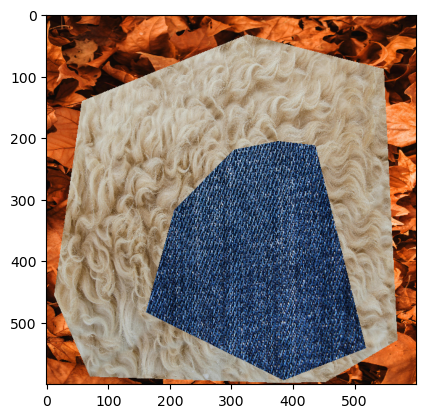

In [189]:
plt.imshow(generateImages(600, l, 3));

Image generation pipeline

(-0.5, 299.5, 299.5, -0.5)

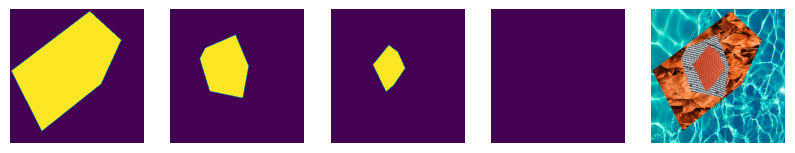

In [50]:
p = genPolyMasks(3, 2, 10)
annotations = generateMatrices(300, p)
image = generateImages(300, p, 3)

plt.figure(figsize=(10,10))

for i in range(len(annotations)):
    plt.subplot(1, len(annotations)+1, i+1)
    annotations[i][0]  = 0
    plt.imshow(annotations[i])
    plt.axis("off")
    
plt.subplot(1, len(annotations)+1, len(annotations)+1)
plt.imshow(image)
plt.axis("off")

Generate dataset

In [20]:
from pathlib import Path
import os
import pickle

In [59]:
n = 1000
root_dir = Path(".") / f"DPoly_plain_{n}"

os.mkdir(root_dir)
os.mkdir(root_dir / "RCNNAnnotations")
os.mkdir(root_dir / "data")
for i in range(n):
    p = genPolyMasks(3, 2, 10)
    annotations = generateMatrices(300, p)
    image = generateImages(300, p, 1)
    
    cv2.imwrite(str(root_dir / "data" / f"{i}.png"), image)
    
    with open(root_dir / "RCNNAnnotations" / f"{i}.pkl", "wb") as out_f:
        pickle.dump(annotations, out_f)
        
    print(f"Image: {i}", end="\r")

In [19]:
annotations

[array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)]

---------

In [8]:
def getRandomSeedPoint(valid_mask: np.ndarray, neighbour=1):
    height, width = valid_mask.shape
    
    while True:
        seed_x, seed_y = random.randint(0, height-1), random.randint(0, width-1)
        if valid_mask[seed_x, seed_y] >= neighbour:
            break
        
    return seed_x, seed_y    

In [75]:
getRandomSeedPoint(np.ones((10, 10)))

(3, 5)

In [9]:
def fillRegion(mask, valid_mask, seed_x, seed_y, min_area=18, fill_val=1):
    "breadth first search to exapnd each level one be one"
    
    area = 0
    height, width = valid_mask.shape
    points = [(seed_x, seed_y)]
    isValid = lambda x, y : x>=0 and y>=0 and x<height and y<width and valid_mask[x,y] == 1 and mask[x,y] != fill_val and random.random() < 0.3
    
    p = 0.2
    while points:
        # fill the point
        x, y = points.pop(0)
        mask[x, y] = fill_val
        # print(f"filling: {x, y}")
        area += 1
                
        # add next set of points
        if isValid(x-1, y-1) :
            points.append((x-1, y-1))
        if isValid(x-1, y)  :
            points.append((x-1, y))
        if isValid(x-1, y+1)  :
            points.append((x-1, y+1))
        if isValid(x, y-1)  :
            points.append((x, y-1))
        if isValid(x, y+1)  :
            points.append((x, y+1))
        if isValid(x+1, y-1)  :
            points.append((x+1, y-1))
        if isValid(x+1, y)  :
            points.append((x+1, y))
        if isValid(x+1, y+1) :
            points.append((x+1, y+1))
      
            

In [10]:
def genLevelAnnotation(valid_mask):
    mask = np.zeros_like(valid_mask)
    
    # find a random point with all neighbours > 0
    seed_x, seed_y = getRandomSeedPoint(valid_mask)
    print(seed_x, seed_y)
    # fill region
    fillRegion(mask, valid_mask, seed_x, seed_y)
    return mask

81 72


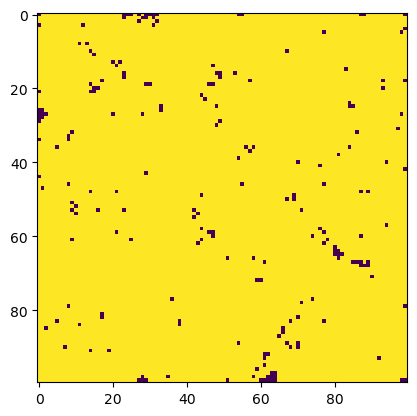

In [158]:
plt.imshow(genLevelAnnotation(np.ones((100, 100))))

In [11]:
def generateAnnotationMatrix(height, width, n_levels=5, n_fragments=3):
    
    valid_mask = np.zeros((height, width))
    masks = []
    while n_levels > 0:
        # processing
        level_mask = genLevelAnnotation(valid_mask)
        
        masks.append(level_mask)
        n_levels -= 1
        
        # stopping nesting
        if random.random() > 0.9:
            break
        
    return masks

In [52]:
generateAnnotationMatrix(10, 10, 4)

4
3
2
1


[]